In [1]:
from zipfile import ZipFile
#file_name = 'Dataset_New.zip'
#file_name = 'Dataset_New.zip'
#file_name = 'NewDataset7_4.zip'
file_name = 'DataSet_New_2.zip'
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done') 

Done


In [2]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.optim import lr_scheduler
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.4.0
Torchvision Version:  0.5.0


In [3]:
# Top level data directory. 

#data_dir = "./Dataset_New"
#data_dir = "./Dataset_New_Balance/Dataset_New_Balance"
data_dir = "./DataSet_New_2"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"  

# Number of classes in the dataset
num_classes = 2

# Batch size for training 
batch_size = 4

# Number of epochs to train for 
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

In [4]:
##this function for label smoothing 
import torch.nn.functional as F
import random
eps_val = random.uniform(0.1, 0.25)
print(eps_val)
def linear_combination(x, y, epsilon): 
    return epsilon*x + (1-epsilon)*y
def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss

class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon:float=eps_val, reduction='mean'):
        super().__init__()
        self.epsilon = epsilon
        self.reduction = reduction
    
    def forward(self, preds, target):
        n = preds.size()[-1]
        log_preds = F.log_softmax(preds, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return linear_combination(loss/n, nll, self.epsilon)

0.14139475088274855


In [5]:
# FGSM attack code------Adversarial Learning
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [6]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()
    train_acc_history = []
    val_hist = []
    examples_All = []
    epsilon = 0.0
    best_acc = 0

    for epoch in range(num_epochs):
        scheduler.step() 
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(True):
                if is_inception:
                    outputs, aux_outputs = model(inputs)
                    loss1 = criterion(outputs, labels)
                    loss2 = criterion(aux_outputs, labels)
                    loss = loss1 + 0.4*loss2
                else:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                if (epoch%10==0):
              
                   #model.zero_grad()
                    data_grad = Variable(inputs.to(device).float(), requires_grad=True)
                    perturbed_data = fgsm_attack(inputs, epsilon, data_grad)
                    ###########################################################
                    if is_inception:
                        outputs, aux_outputs = model(perturbed_data)
                    else:
                        outputs = model(perturbed_data)
                    
                    ###########################################################
                    #outputs = model(perturbed_data)
                   #preds= outputs.max(1, keepdim=True)[1]
                    outputs = nn.functional.softmax(outputs,dim = 1)
                    _, preds = torch.max(outputs, 1)
                    model.zero_grad()
                    loss.backward()
                    optimizer.step()
                    if epsilon<=3:
                        epsilon  = epsilon+0.05
                    else:
                        epsilon = 3
            
                else:
                    outputs = nn.functional.softmax(outputs,dim = 1)
                    _, preds = torch.max(outputs, 1)
                    loss.backward()
                    optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)    
        epoch_loss = running_loss / len(dataloaders['train'].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders['train'].dataset)
        train_acc_history.append(epoch_acc)
        print('{} Loss: {:.4f} Acc: {:.4f}'.format('train', epoch_loss, epoch_acc))
        ############################################################
        
        accuracies = []
        examples = []
        prob = []
         
        # Run test for each epsilon
        for eps in epsilons:
            acc, ex ,prob,adv_ex_All,init_labels,final_labels= test(model_ft, device, dataloaders_dict_v, eps)
            accuracies.append(acc)
            examples.append(ex)
            examples_All.append(adv_ex_All)
            prob.append(prob)
            if eps==0:
                val_hist.append(acc)
            if eps == 0 and acc > best_acc:
                best_acc = acc
                #best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(train_model,'./TL_weights/weights'+str(epoch)+'.pth')

        plt.figure(figsize=(5,5))
        plt.plot(epsilons, accuracies, "*-")
        plt.yticks(np.arange(0, 1.1, step=0.1))
        plt.xticks(np.arange(0, .35, step=0.05))
        plt.title("Accuracy vs Epsilon")
        plt.xlabel("Epsilon")
        plt.ylabel("validation Accuracy")
        plt.show()
        # Plot several examples of adversarial samples at each epsilon
        cnt = 0
        plt.figure(figsize=(8,10))
        
        for i in range(len(epsilons)):
            
            for j in range(len(examples[i])):
                cnt += 1
                plt.subplot(len(epsilons),len(examples[0]),cnt)
                plt.xticks([], [])
                plt.yticks([], [])
                if j == 0:
                    plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
                orig,adv,ex = examples[i][j]
                p = prob[i+cnt-1]
                plt.title("{} -> {}-{:.2f}".format(orig, adv,p))
                plt.imshow(ex[1])#, cmap="gray")
                
                
        plt.tight_layout()
        plt.show()
        
        
        ############################################################
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    #print('Best Model Weights')
    #print(model.load_state_dict(best_model_wts))
    
    return model, train_acc_history,val_hist,examples,examples_All,init_labels,final_labels

In [7]:
epsilons = [0, .05, .1, .15, .2, .25, .3]

In [8]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []
    adv_examples_prob = []
    adv_ex_All = []
    init_labels = []
    final_labels = []
    
    model.eval()
    len_test_loader = 0
    # Loop over all examples in test set
    for data, target in test_loader['val']:
        len_test_loader += 1
        # Send the data and label to the device
        data = data.to(device)
        target = target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        output = nn.functional.softmax(output,dim = 1)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success

        output = nn.functional.softmax(output,dim = 1)
        prob, final_pred = torch.max(output, 1)
        #final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        adv_examples_prob.append(prob.item())
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
                adv_examples_prob.append(prob.item())
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
                #adv_examples_prob.append(prob.item())
            else:
                adv_ex_all = perturbed_data.squeeze().detach().cpu().numpy()
                adv_ex_All.append(adv_ex_all)
                init_labels.append(init_pred.item())
                final_labels.append(final_pred.item())
    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len_test_loader)
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len_test_loader, final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples, adv_examples_prob,adv_ex_All,init_labels,final_labels


In [9]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [10]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        #,transforms.Grayscale(num_output_channels=1)
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets_t = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train']}
# Create training and validation dataloaders
dataloaders_dict_t = {x: torch.utils.data.DataLoader(image_datasets_t[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train']}

# Create training and validation datasets
image_datasets_v = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['val']}
# Create training and validation dataloaders
dataloaders_dict_v = {x: torch.utils.data.DataLoader(image_datasets_v[x],batch_size = 1, num_workers=0) for x in ['val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [12]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 fc.weight
	 fc.bias


Epoch 0/14
----------


/home/naveen/vEnv3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.5201 Acc: 0.6281
Epsilon: 0	Test Accuracy = 524 / 764 = 0.6858638743455497
Epsilon: 0.05	Test Accuracy = 470 / 764 = 0.6151832460732984
Epsilon: 0.1	Test Accuracy = 471 / 764 = 0.6164921465968587
Epsilon: 0.15	Test Accuracy = 474 / 764 = 0.6204188481675392
Epsilon: 0.2	Test Accuracy = 471 / 764 = 0.6164921465968587
Epsilon: 0.25	Test Accuracy = 466 / 764 = 0.6099476439790575
Epsilon: 0.3	Test Accuracy = 448 / 764 = 0.5863874345549738


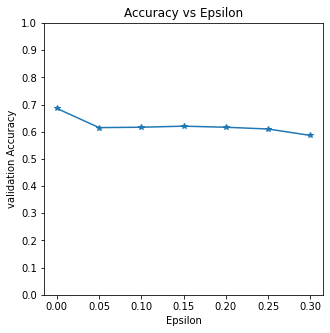

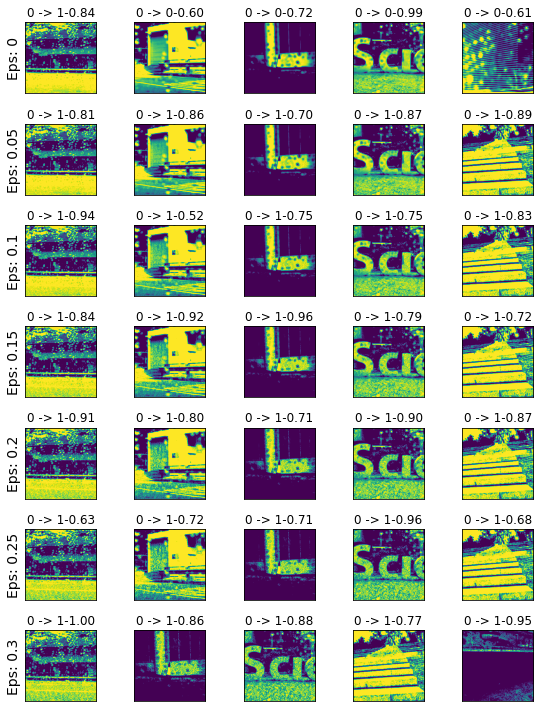

Epoch 1/14
----------
train Loss: 0.4489 Acc: 0.7785
Epsilon: 0	Test Accuracy = 414 / 764 = 0.5418848167539267
Epsilon: 0.05	Test Accuracy = 221 / 764 = 0.2892670157068063
Epsilon: 0.1	Test Accuracy = 228 / 764 = 0.29842931937172773
Epsilon: 0.15	Test Accuracy = 219 / 764 = 0.28664921465968585
Epsilon: 0.2	Test Accuracy = 228 / 764 = 0.29842931937172773
Epsilon: 0.25	Test Accuracy = 241 / 764 = 0.31544502617801046
Epsilon: 0.3	Test Accuracy = 238 / 764 = 0.31151832460732987


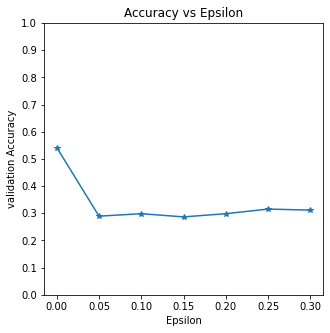

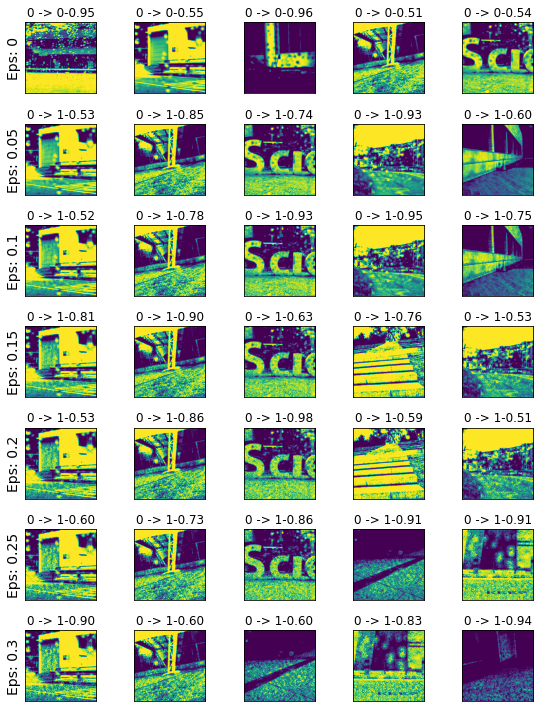

Epoch 2/14
----------
train Loss: 0.4949 Acc: 0.7680
Epsilon: 0	Test Accuracy = 533 / 764 = 0.6976439790575916
Epsilon: 0.05	Test Accuracy = 454 / 764 = 0.5942408376963351
Epsilon: 0.1	Test Accuracy = 454 / 764 = 0.5942408376963351
Epsilon: 0.15	Test Accuracy = 446 / 764 = 0.5837696335078534
Epsilon: 0.2	Test Accuracy = 444 / 764 = 0.581151832460733
Epsilon: 0.25	Test Accuracy = 443 / 764 = 0.5798429319371727
Epsilon: 0.3	Test Accuracy = 440 / 764 = 0.5759162303664922


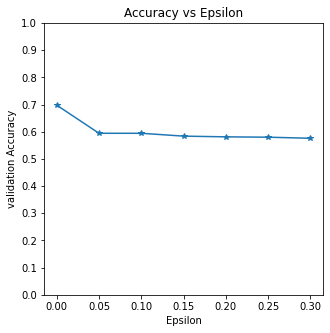

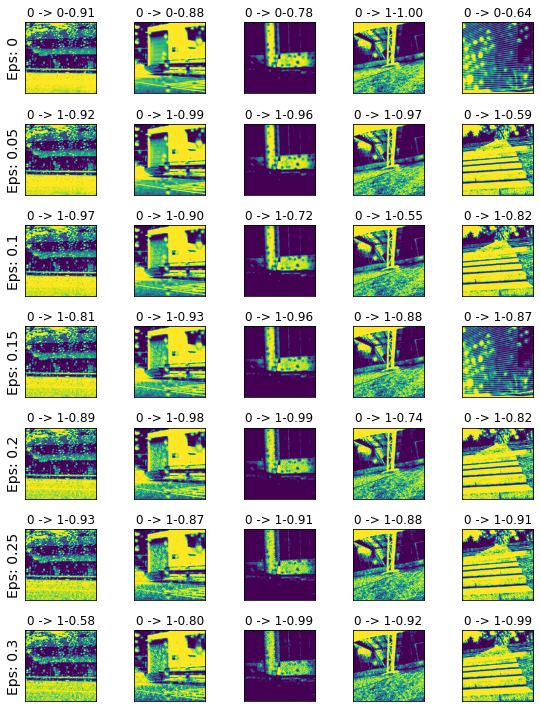

Epoch 3/14
----------
train Loss: 0.4907 Acc: 0.7624
Epsilon: 0	Test Accuracy = 564 / 764 = 0.7382198952879581
Epsilon: 0.05	Test Accuracy = 377 / 764 = 0.49345549738219896
Epsilon: 0.1	Test Accuracy = 361 / 764 = 0.4725130890052356
Epsilon: 0.15	Test Accuracy = 357 / 764 = 0.46727748691099474
Epsilon: 0.2	Test Accuracy = 365 / 764 = 0.47774869109947643
Epsilon: 0.25	Test Accuracy = 369 / 764 = 0.4829842931937173
Epsilon: 0.3	Test Accuracy = 354 / 764 = 0.46335078534031415


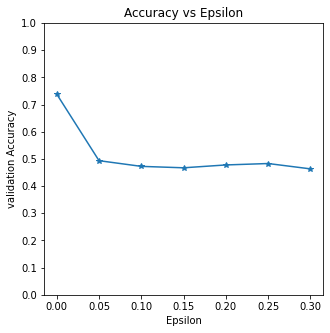

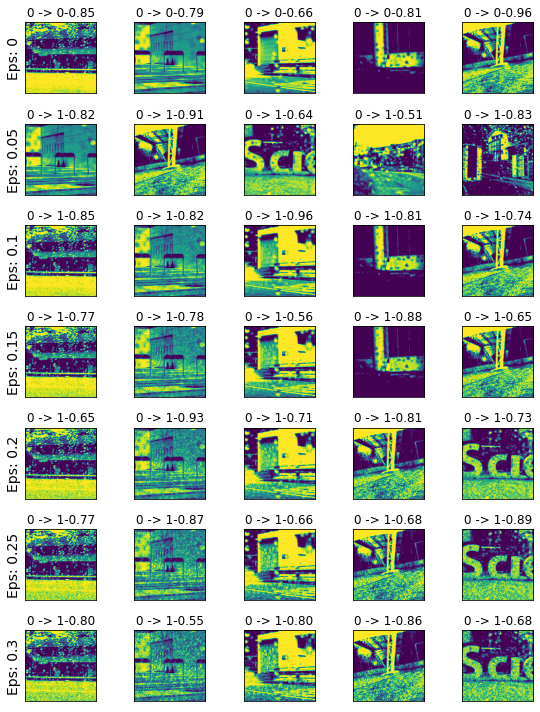

Epoch 4/14
----------
train Loss: 0.4774 Acc: 0.7600
Epsilon: 0	Test Accuracy = 519 / 764 = 0.6793193717277487
Epsilon: 0.05	Test Accuracy = 415 / 764 = 0.5431937172774869
Epsilon: 0.1	Test Accuracy = 404 / 764 = 0.5287958115183246
Epsilon: 0.15	Test Accuracy = 393 / 764 = 0.5143979057591623
Epsilon: 0.2	Test Accuracy = 383 / 764 = 0.5013089005235603
Epsilon: 0.25	Test Accuracy = 370 / 764 = 0.48429319371727747
Epsilon: 0.3	Test Accuracy = 354 / 764 = 0.46335078534031415


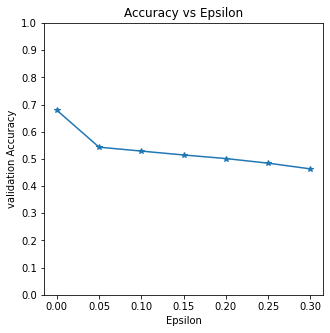

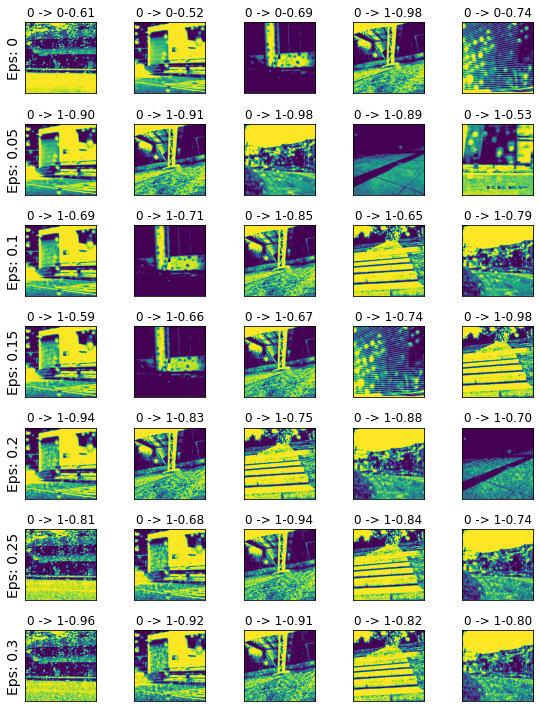

Epoch 5/14
----------
train Loss: 0.4726 Acc: 0.7646
Epsilon: 0	Test Accuracy = 536 / 764 = 0.7015706806282722
Epsilon: 0.05	Test Accuracy = 407 / 764 = 0.5327225130890052
Epsilon: 0.1	Test Accuracy = 409 / 764 = 0.5353403141361257
Epsilon: 0.15	Test Accuracy = 411 / 764 = 0.5379581151832461
Epsilon: 0.2	Test Accuracy = 402 / 764 = 0.5261780104712042
Epsilon: 0.25	Test Accuracy = 397 / 764 = 0.5196335078534031
Epsilon: 0.3	Test Accuracy = 387 / 764 = 0.506544502617801


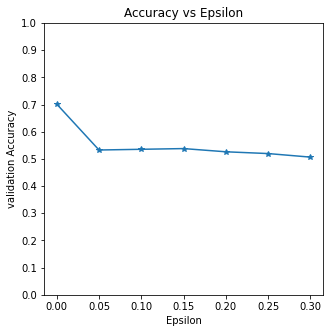

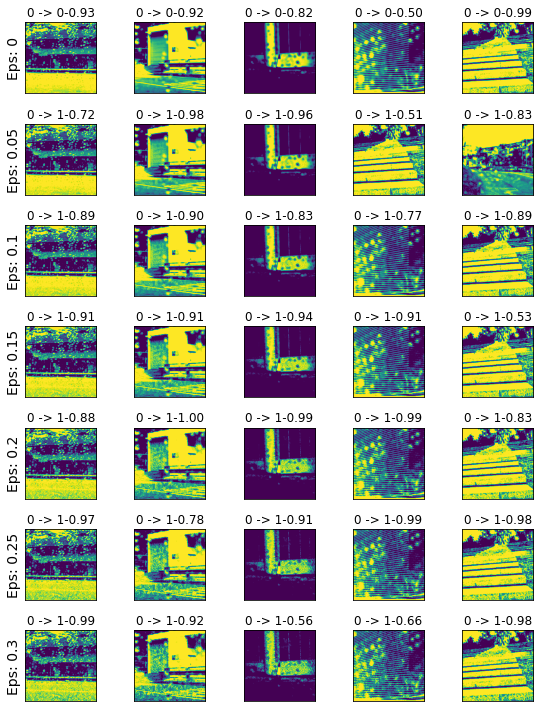

Epoch 6/14
----------
train Loss: 0.4884 Acc: 0.7634
Epsilon: 0	Test Accuracy = 531 / 764 = 0.6950261780104712
Epsilon: 0.05	Test Accuracy = 349 / 764 = 0.4568062827225131
Epsilon: 0.1	Test Accuracy = 324 / 764 = 0.42408376963350786
Epsilon: 0.15	Test Accuracy = 318 / 764 = 0.4162303664921466
Epsilon: 0.2	Test Accuracy = 322 / 764 = 0.4214659685863874
Epsilon: 0.25	Test Accuracy = 313 / 764 = 0.4096858638743455
Epsilon: 0.3	Test Accuracy = 303 / 764 = 0.39659685863874344


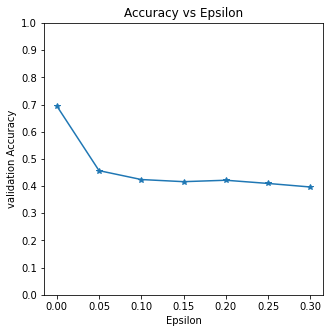

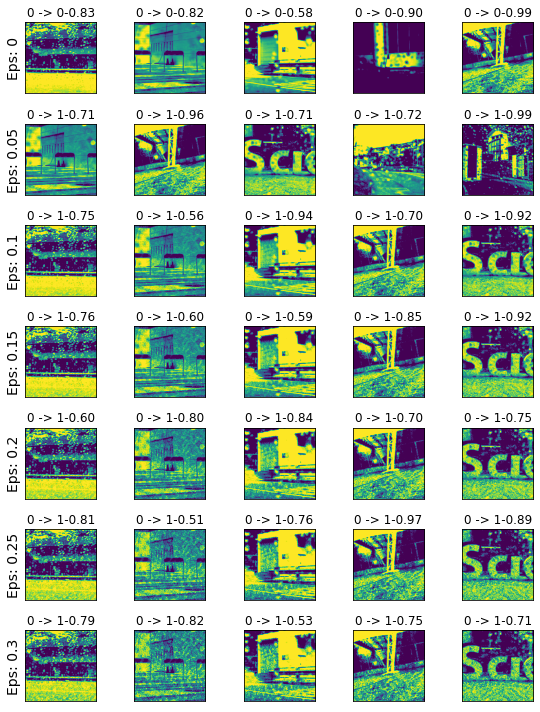

Epoch 7/14
----------
train Loss: 0.4839 Acc: 0.7646
Epsilon: 0	Test Accuracy = 494 / 764 = 0.6465968586387435
Epsilon: 0.05	Test Accuracy = 313 / 764 = 0.4096858638743455
Epsilon: 0.1	Test Accuracy = 275 / 764 = 0.3599476439790576
Epsilon: 0.15	Test Accuracy = 268 / 764 = 0.3507853403141361
Epsilon: 0.2	Test Accuracy = 259 / 764 = 0.3390052356020942
Epsilon: 0.25	Test Accuracy = 253 / 764 = 0.331151832460733
Epsilon: 0.3	Test Accuracy = 248 / 764 = 0.32460732984293195


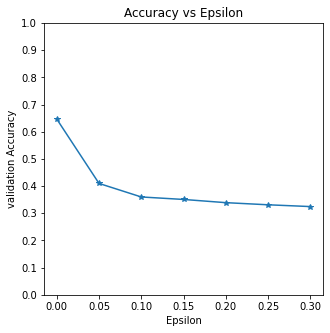

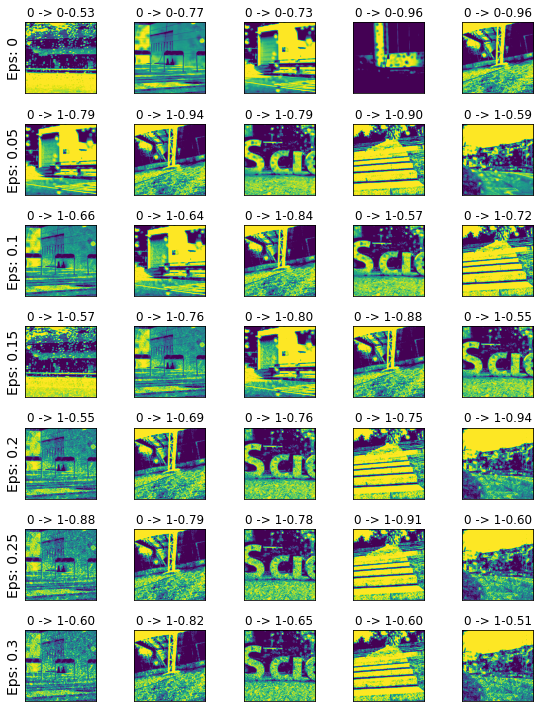

Epoch 8/14
----------
train Loss: 0.4895 Acc: 0.7640
Epsilon: 0	Test Accuracy = 532 / 764 = 0.6963350785340314
Epsilon: 0.05	Test Accuracy = 340 / 764 = 0.44502617801047123
Epsilon: 0.1	Test Accuracy = 316 / 764 = 0.41361256544502617
Epsilon: 0.15	Test Accuracy = 305 / 764 = 0.3992146596858639
Epsilon: 0.2	Test Accuracy = 295 / 764 = 0.38612565445026176
Epsilon: 0.25	Test Accuracy = 292 / 764 = 0.38219895287958117
Epsilon: 0.3	Test Accuracy = 281 / 764 = 0.36780104712041883


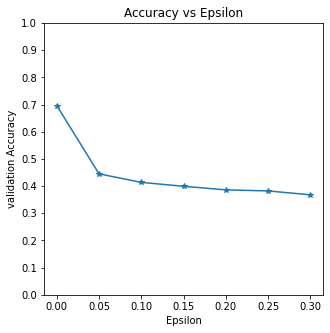

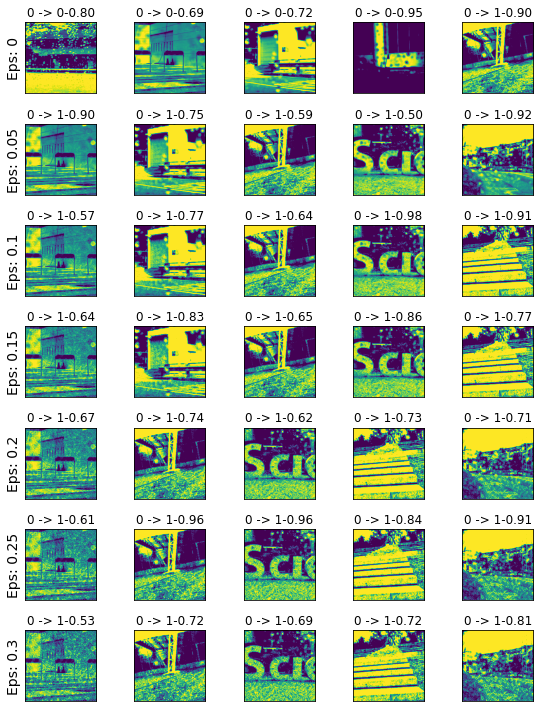

Epoch 9/14
----------
train Loss: 0.4957 Acc: 0.7544
Epsilon: 0	Test Accuracy = 542 / 764 = 0.7094240837696335
Epsilon: 0.05	Test Accuracy = 426 / 764 = 0.5575916230366492
Epsilon: 0.1	Test Accuracy = 414 / 764 = 0.5418848167539267
Epsilon: 0.15	Test Accuracy = 407 / 764 = 0.5327225130890052
Epsilon: 0.2	Test Accuracy = 399 / 764 = 0.5222513089005235
Epsilon: 0.25	Test Accuracy = 387 / 764 = 0.506544502617801
Epsilon: 0.3	Test Accuracy = 372 / 764 = 0.4869109947643979


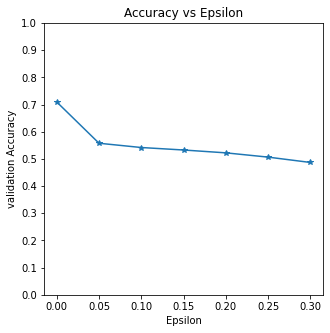

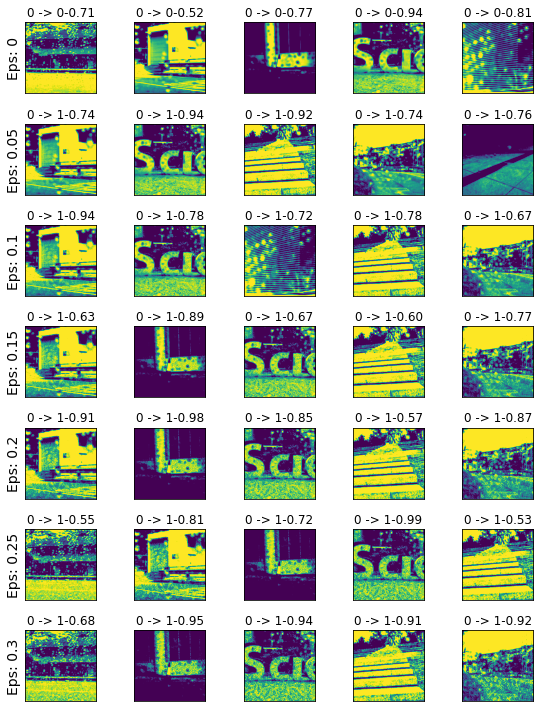

Epoch 10/14
----------
train Loss: 0.4368 Acc: 0.6608
Epsilon: 0	Test Accuracy = 434 / 764 = 0.5680628272251309
Epsilon: 0.05	Test Accuracy = 306 / 764 = 0.4005235602094241
Epsilon: 0.1	Test Accuracy = 280 / 764 = 0.36649214659685864
Epsilon: 0.15	Test Accuracy = 260 / 764 = 0.3403141361256545
Epsilon: 0.2	Test Accuracy = 252 / 764 = 0.3298429319371728
Epsilon: 0.25	Test Accuracy = 230 / 764 = 0.3010471204188482
Epsilon: 0.3	Test Accuracy = 209 / 764 = 0.27356020942408377


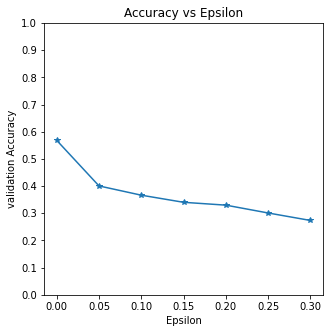

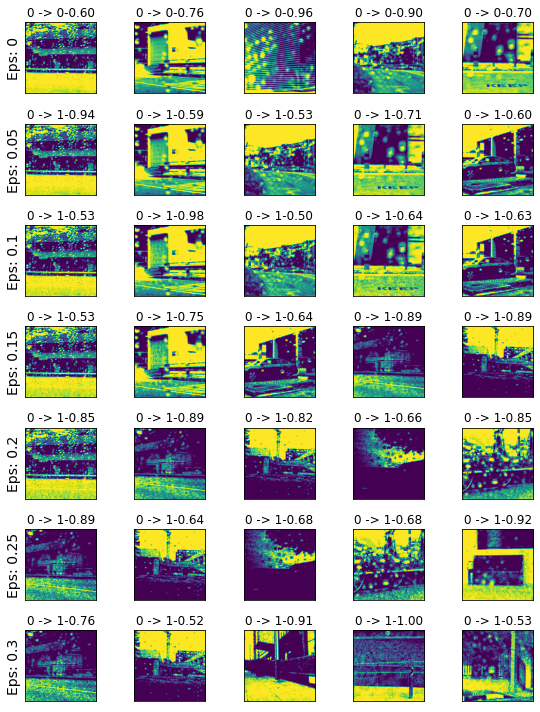

Epoch 11/14
----------
train Loss: 0.4686 Acc: 0.7773
Epsilon: 0	Test Accuracy = 496 / 764 = 0.6492146596858639
Epsilon: 0.05	Test Accuracy = 423 / 764 = 0.5536649214659686
Epsilon: 0.1	Test Accuracy = 413 / 764 = 0.5405759162303665
Epsilon: 0.15	Test Accuracy = 393 / 764 = 0.5143979057591623
Epsilon: 0.2	Test Accuracy = 385 / 764 = 0.5039267015706806
Epsilon: 0.25	Test Accuracy = 366 / 764 = 0.4790575916230366
Epsilon: 0.3	Test Accuracy = 358 / 764 = 0.468586387434555


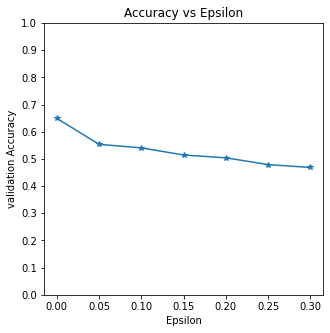

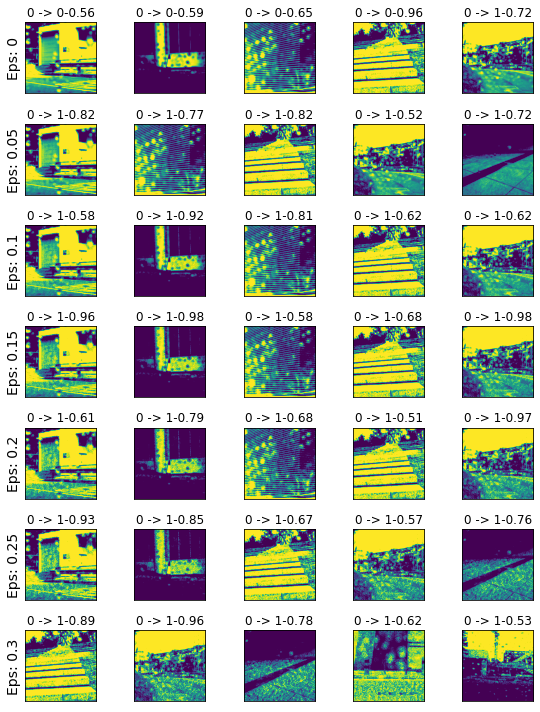

Epoch 12/14
----------
train Loss: 0.4911 Acc: 0.7661
Epsilon: 0	Test Accuracy = 554 / 764 = 0.725130890052356
Epsilon: 0.05	Test Accuracy = 385 / 764 = 0.5039267015706806
Epsilon: 0.1	Test Accuracy = 381 / 764 = 0.4986910994764398
Epsilon: 0.15	Test Accuracy = 380 / 764 = 0.4973821989528796
Epsilon: 0.2	Test Accuracy = 372 / 764 = 0.4869109947643979
Epsilon: 0.25	Test Accuracy = 373 / 764 = 0.4882198952879581
Epsilon: 0.3	Test Accuracy = 376 / 764 = 0.49214659685863876


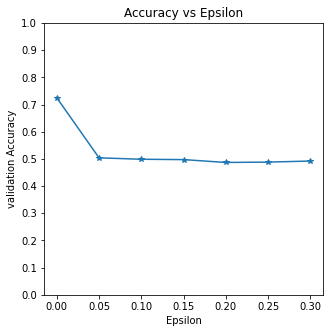

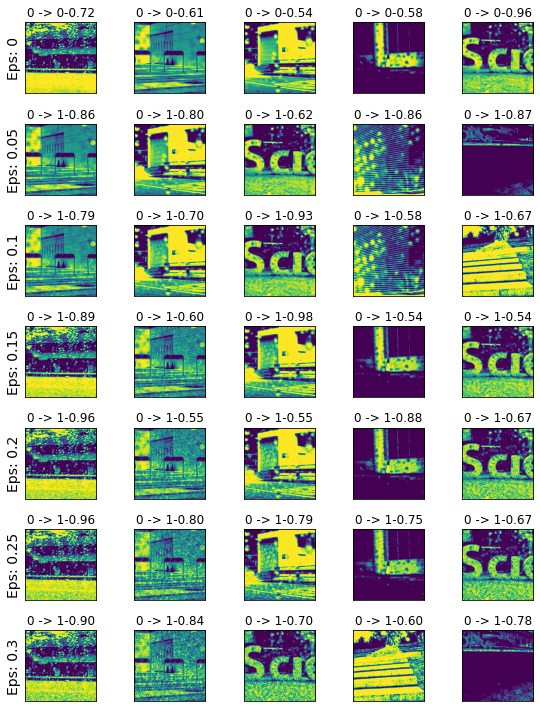

Epoch 13/14
----------
train Loss: 0.4220 Acc: 0.7890
Epsilon: 0	Test Accuracy = 542 / 764 = 0.7094240837696335
Epsilon: 0.05	Test Accuracy = 444 / 764 = 0.581151832460733
Epsilon: 0.1	Test Accuracy = 431 / 764 = 0.5641361256544503
Epsilon: 0.15	Test Accuracy = 427 / 764 = 0.5589005235602095
Epsilon: 0.2	Test Accuracy = 428 / 764 = 0.5602094240837696
Epsilon: 0.25	Test Accuracy = 424 / 764 = 0.5549738219895288
Epsilon: 0.3	Test Accuracy = 417 / 764 = 0.5458115183246073


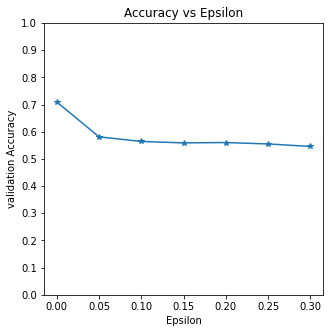

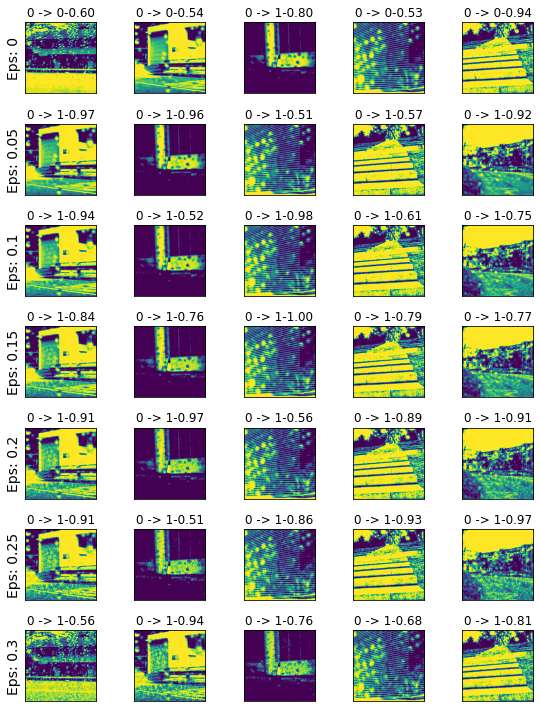

Epoch 14/14
----------
train Loss: 0.4672 Acc: 0.7723
Epsilon: 0	Test Accuracy = 483 / 764 = 0.6321989528795812
Epsilon: 0.05	Test Accuracy = 317 / 764 = 0.41492146596858637
Epsilon: 0.1	Test Accuracy = 300 / 764 = 0.39267015706806285
Epsilon: 0.15	Test Accuracy = 292 / 764 = 0.38219895287958117
Epsilon: 0.2	Test Accuracy = 297 / 764 = 0.3887434554973822
Epsilon: 0.25	Test Accuracy = 314 / 764 = 0.4109947643979058
Epsilon: 0.3	Test Accuracy = 318 / 764 = 0.4162303664921466


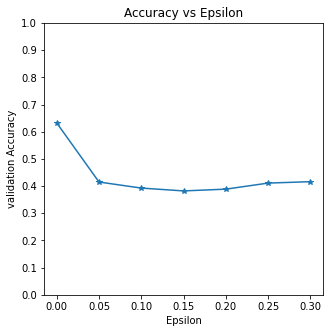

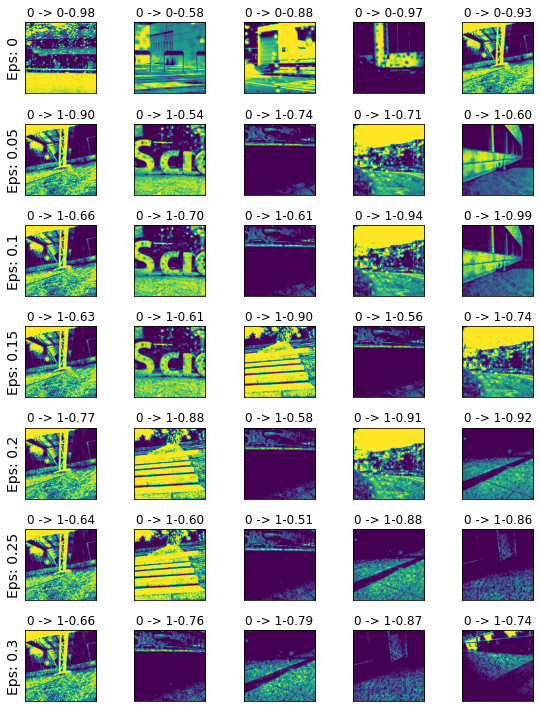

Training complete in 18m 29s


In [13]:
### in this part you can choose which (criterion/learning rate scheduler) you want to use

#criterion = nn.CrossEntropyLoss()
#scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.7)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer_ft,T_max=100 )
weights = torch.tensor([0.3,0.7])
weights = weights.to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
#criterion = LabelSmoothingCrossEntropy()
model_ft,train_hist,val_hist,ex,ex_all,init_labels,final_labels = train_model(model_ft, dataloaders_dict_t, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))


In [14]:
print('the labels before implementing adversarial learning')
print(init_labels)


the labels before implementing adversarial learning
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [15]:
print('the labels after implementing adversarial learning')
print(final_labels)

the labels after implementing adversarial learning
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Text(0.5, 0, 'epoch')

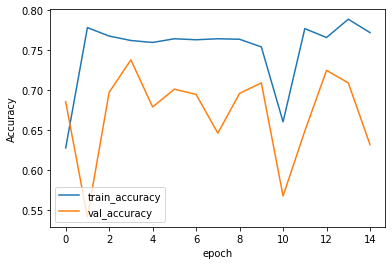

In [16]:
train_accuracy =train_hist
val_accuracy = val_hist
num_epochs = num_epochs
x =range(0,num_epochs)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x,train_accuracy, label='train_accuracy')
ax.plot(x,val_accuracy, label='val_accuracy')
leg1 = ax.legend(loc='lower left')
ax.set_ylabel('Accuracy')
ax.set_xlabel('epoch')

In [17]:
print(max(val_hist))
ind = val_hist.index(max(val_hist))
print(ind)
print(train_hist[ind])

0.7382198952879581
3
tensor(0.7624, device='cuda:0', dtype=torch.float64)


In [18]:
print(np.array(ex_all).shape)

(105,)


In [19]:
# # #this part for saving the adversarial images don't run if there is no need to save them 
# import cv2
# from PIL import Image
# np.array(ex_all)
# i = 0
# j=0
# while(True):
#     try:
#         while(True):
#             try:
#             #im = np.array(ex_all[i][j])*255
#                 im = (ex_all[i][j])*255
#                 #print(im.shape)
#                 arr = im.transpose(1, 2, 0)
#                 cv2.imwrite('AL_Examples/sample_out_'+str(i)+str(j)+'.jpg', cv2.cvtColor(arr, cv2.COLOR_RGB2BGR))
#                 print('image'+str(i)+','+str(j))
#                 j = j+1
#             except Exception as e:
#                 print(e)
#                 j = 0
#                 i = i+1
#                 continue
#     except Exception as e:
#         break

In [10]:
##This part of code to get insight of trained model using python library: Captum
from captum.insights import AttributionVisualizer, Batch
from captum.insights.features import ImageFeature
from captum.attr import GradientShap
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
from PIL import ImageChops
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from torchvision import datasets, models, transforms
import torch.nn.functional as F
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)
#Code to load trained model
#weight_file = '/home/ruchita/Downloads/BestWeights.pth'
#model_ft = torch.load(weight_file,map_location=torch.device('cpu'))

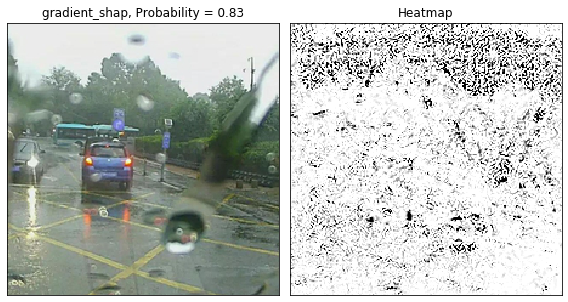

In [11]:
input_size = 224
#img = Image.open('./DataSet_New_2/sample_out_2.jpg')#Image which is used to get insight
img = Image.open('/home/ruchita/CourseWork/EE769/Project Work/NewDataset5_4/Archive-89ca/Dataset_New/train/Distortion/train_dry_993.jpg')
tx = transforms.Compose([
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),])
tn=transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
transformed_img =tx(img)
input = tn(transformed_img)
input = input.unsqueeze(0)
output = model_ft(input)#
rand_img_dist = torch.cat([input * 0, input * 255])
output = F.softmax(output, dim=1)

prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
predicted_label = str(pred_label_idx)#idx_to_labels[str(pred_label_idx.item())][1]

gradient_shap = GradientShap(model_ft)
attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                        np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                        methods=["original_image", "heat_map"],
                        signs=['all', 'positive'],
                        titles=["gradient_shap, Probability = "+str(round(float(output[0][0]),2)),"Heatmap"],
                        cmap=default_cmap)


In [22]:

# # # Let us compute attributions using Integrated Gradients and smoothens
# # #them across multiple images generated by a <em>noise tunnel</em>.
# # #The latter adds gaussian noise with a std equals to one, 
# # #10 times (n_samples=10) to the input. 
# # #Ultimately, noise tunnel smoothens the attributions across `n_samples` 
# # #noisy samples using `smoothgrad_sq` technique.
# # #`smoothgrad_sq` represents the mean of the squared attributions across
# # #`n_samples` samples.


# noise_tunnel = NoiseTunnel(integrated_gradients)

# attributions_ig_nt = noise_tunnel.attribute(input, n_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
# _ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
#                                       np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
#                                       ["original_image", "heat_map"],
#                                       ["all", "positive"],
#                                       cmap=default_cmap,
#                                       show_colorbar=True)

In [23]:
# # # Finally, let us use `GradientShap`, a linear explanation model which 
# # #uses a distribution of reference samples (in this case two images) to 
# # #explain predictions of the model. It computes the expectation of 
# # #gradients for an input which was chosen randomly between the input and 
# # #a baseline. The baseline is also chosen randomly from given baseline 
# # #distribution.
# torch.manual_seed(0)
# np.random.seed(0)

# gradient_shap = GradientShap(model_ft)

# # Defining baseline distribution of images
# rand_img_dist = torch.cat([input.to(device) * 0, input.to(device) * 1])

# attributions_gs = gradient_shap.attribute(input.to(device),
#                                           n_samples=50,
#                                           stdevs=0.0001,
#                                           baselines=rand_img_dist,
#                                           target=pred_label_idx)
# _ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
#                                       np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
#                                       ["original_image", "heat_map"],
#                                       ["all", "absolute_value"],
#                                       cmap=default_cmap,
#                                       show_colorbar=True)

In [24]:
# # # ## 3- Occlusion-based attribution

# # # Now let us try a different approach to attribution. We can estimate 
# # #which areas of the image are critical for the classifier's decision 
# # #by occluding them and quantifying how the decision changes.
# # # 
# # # We run a sliding window of size 15x15 (defined via `sliding_window_shapes`) 
# # #with a stride of 8 along both image dimensions (a defined via `strides`).
# # #At each location, we occlude the image with a baseline value of 0 which
# # #correspondes to a gray patch (defined via `baselines`).
# # # 
# # # **Note:** this computation might take more than one minute to complete,
# # #as the model is evaluated at every position of the sliding window.
# occlusion = Occlusion(model_ft)

# attributions_occ = occlusion.attribute(input.to(device),
#                                        strides = (3, 8, 8),
#                                        target=pred_label_idx,
#                                        sliding_window_shapes=(3,15, 15),
#                                        baselines=0)
# ## Let us visualize the attribution, focusing on the areas with positive attribution 
# ##(those that are critical for the classifier's decision):
# _ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
#                                       np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
#                                       ["original_image", "heat_map"],
#                                       ["all", "positive"],
#                                       show_colorbar=True,
#                                       outlier_perc=2,
#                                      )
# ##We can verify further which part more important by occluding the 
# ##image using a larger sliding window:
# occlusion = Occlusion(model_ft)

# attributions_occ = occlusion.attribute(input.to(device),
#                                        strides = (3, 50, 50),
#                                        target=pred_label_idx,
#                                        sliding_window_shapes=(3,60, 60),
#                                        baselines=0)

# _ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
#                                       np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
#                                       ["original_image", "heat_map"],
#                                       ["all", "positive"],
#                                       show_colorbar=True,
#                                       outlier_perc=2,
#                                      )

